In [2]:
import shutil,os,string
import numpy as np
from IPython.display import HTML 
HTML('../style/course.css')
HTML('../style/code_toggle.html')
import matplotlib.image as mim
import matplotlib.pyplot as ppl
from subprocess import *
from astropy.io import fits

def Run(command,verb1=1,verb2=0,getout=0):
    if verb1: print command
    result=string.split(Popen(string.split(command),stdout=PIPE).communicate()[0],'\n')
    if verb2:
        for jj in result: print jj
    if getout: return result

print '# Done importing'

# Done importing


# Continuum subtraction

## Outline

**1.** <a href="http://localhost:8888/notebooks/contsub.ipynb#1.-Preliminary-considerations">Preliminary considerations</a>

**2.** <a href="http://localhost:8888/notebooks/contsub.ipynb#1.-Overview-of-continuum-subtraction-methods">Overview of continuum subtraction methods</a>

**3.** <a href="http://localhost:8888/notebooks/contsub.ipynb#2.-Cube-based-continuum-subtraction">Cube-based continuum subtraction</a>

**4.** <a href="http://localhost:8888/notebooks/contsub.ipynb#3.-Visibility-based-continuum-subtraction">Visibility-based continuum subtraction</a>

**5.** <a href="http://localhost:8888/notebooks/contsub.ipynb#4.-Model-based-continuum-subtraction">Model-based continuum subtraction</a>

**6.** <a href="http://localhost:8888/notebooks/contsub.ipynb#6.-Concluding-remarks">Concluding remarks</a>

## 1. Preliminary considerations

### 1.1. Notation

The analysis and interpretation of spectral-line data is greatly simplified if all sources of continuum emission have already been removed from the data. This chapter describes the methods that can be used to subtract radio continuum emission from visibility datasets or datacubes, resulting in data that contain spectral-line emission and/or absorption only. Here we will adopt the following notation:
- $S(l,m,\nu)$ is the sky brightness as a function of position (relative to a reference position $l_0,m_0$, which we assume to be both the pointing and phase-tracking centre) and frequency;
- $A(l,m,\nu)$ is the primary beam pattern;
- $I(l,m,\nu) = S(l,m,\nu) \cdot A(l,m,\nu)$ is the apparent sky brightness;
- $B(l,m,\nu)$ is the point spread function or PSF;
- $I^\mathrm{D}(l,m,\nu)$ is the dirty datacube obtained by convolving $I(l,m,\nu)$ with $B(l,m,\nu)$;
- $\mathbf{b}_{ij}$ is the baseline between antennas $i$ and $j$
- $V_{ij}(t,\nu)$ is the complex visibility for the baseline $\mathbf{b}_{ij}$ at time $t$ and frequency $\nu$; this notation is preferred to the more common $V_{\nu}(u,v)$ because for a given visibility spectrum $V_{ij}(t,\nu)$ the coordinates $u$ and $v$ change with frequency (we will see that this is relevant for continuum subtraction);
- cubes and visibilities are composed of a continuum and a spectral line term, e.g., $I(l,m,\nu) = I_\mathrm{c}(l,m,\nu) + I_\mathrm{s}(l,m,\nu)$ and $V_{ij}(t,\nu) = V_{ij,\mathrm{c}}(t,\nu) + V_{ij,\mathrm{s}}(t,\nu)$.

### 1.2. A note on MIRIAD

In this notebook we use MIRIAD to illustrate various aspects of continuum subtraction. Before proceeding we must therefore comment on one peculiarity of MIRIAD compared to other data reduction software: in datacubes made with MIRIAD the pixel size (in arcsec) scales with $1/\nu$. This means that the sky coordinates $l$ and $m$ of a given cube spatial pixel $(x,y)$ vary with $\nu$.

The main reason for MIRIAD to introduce this scaling is that the PSF pattern, whose size scales as $1/\nu$ in a $(l,m,\nu)$ coordinate grid, remains then fixed in the $(x,y,\nu)$ pixel grid of the datacube. That is, assuming frequency-independent flagging, the PSF pattern is exactly the same for all channels of a MIRIAD datacube. Therefore, the PSF can be represented by a single plane (instead of a full PSF cube!), which can be used efficiently for image-plane deconvolution of all frequency channels.

An important side effect of this "trick" is that sources away from the datacube reference pixel $(l,m)=(0,0)$ move radially in $(x,y)$ as the frequency changes – because their $(l,m)$ must remain fixed. This is not an issue for deconvolution, which is done independently for each channel, but it is a problem for one of the continuum subtraction methods described below (Sec. 3).

Since our aim is to provide a general discussion on continuum subtraction and not to be tied to the specifics of MIRIAD, in this notebook we will regrid all MIRIAD datacubes to a fixed pixel scale. When relevant we will comment on the consequences of working with the original, not regridded MIRIAD cube.

## 2. Overview of continuum subtraction methods

Continuum emission can be removed from interferometric data in a variety of ways, which can be grouped under the following 3 categories:
- *cube based*, where the continuum emission is estimated and subtracted from a dirty cube $I^\mathrm{D}(l,m,\nu)$ or, under some circumstances, a deconvolved cube $I(l,m,\nu)$ -- Sec. 3;
- *visibility based*, where the continuum emission is estimated and subtracted from visibility spectra $V_{ij}(t,\nu)$ -- Sec. 4;
- *model based*, wheren the continuum emission $I_\mathrm{c}(l,m,\nu)$ is modelled from a continuum (possibly multi-frequency) image, and the model is Fourier transformed and subtracted from the visibilities $V_{ij}(t,\nu)$ -- Sec. 5.

Each method has advantages and disadgantages, and often it is advisiable to use more than one method to completely remove continuum emission from the data. As usual, simpler methods are faster but may be less accurate. Important factors affecting their performance include:
- the fractional bandwidth over which one needs to subtract the continuum
- the quality of the calibration
- the distance of the continuum sources from the phase centre
- the brightness of the spectral line relative to the continuum

Below we describe these different methods, their advantages and disadvantages, and how the above factors come into play.

## 3. Cube-based continuum subtraction

### 3.1. Basic method

If no continuum has been subtracted from the visibilities $V_{ij}(t,\nu)$, each sightline ($l,m$) of the dirty cube $I^\mathrm{D}(l,m,\nu)$ will in principle include some level of continuum emission $I^\mathrm{D}_\mathrm{c}(l,m,\nu)\ne0$. This includes both emission at the position of real continuum sources and emission corresponding to their PSF sidelobes. The sidelobes contribution would disappear if one could deconvolve the cube before subtracting the continuum. However, this is ususally not advisable and, for the moment, we assume that the cube is dirty. We will return to the point of deconvolution in Sec. 2.3.

The basic idea of this method is to estimate and remove the continuum component $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ of the dirty cube along each sightline ($l,m$) independently. This can be done by modelling it with a low order polynomial; that is, fit and subtract $I^\mathrm{D}_\mathrm{c,model}(l,m,\nu)=\sum_{n=0}^{N} a_n(l,m)\ \nu^n$ to the line-free channels. In general, for smaller fractional bandwidths the variation of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ with frequency is more limited and, therefore, the order $N$ of the polynomial can be smaller. The limiting case is one where it is sufficient to take the average of all line-free channels (or a $0^\mathrm{th}$-order polynomial fit) as an estimate of a frequency-independent continuum.

### 3.2. Limitations: error at the position of PSF sidelobes

For a correct choice of $N$, note that the variation of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ with frequency is determined not only by the intrinsic continuum spectrum of the sky $S_\mathrm{c}(l,m,\nu)$ but also by the variation of the primary beam $A(l,m,\nu)$ with frequency. The latter is a decreasing function of frequency (within the main lobe) and, therefore, it has the effect of decreasing the spectral slope of the observed sources. Because of such primary beam modulation, two identical sources at different positions within the primary beam will in general have different observed spectral shapes. The order of the polynomial will need to be chosen to deal with the "worst" source in the field.

An additional effect to consider is that of the PSF. At a position of the cube where most of the continuum flux comes from the sidelobes of a nearby source, the observed flux density variation with frequency depends critically on the spatial and frequency structure of the PSF $B(l,m,\nu)$ (note that the PSF variation with frequency may be partly due to frequency-dependent flagging). The resulting frequency dependence of $I^\mathrm{D}_\mathrm{c}(l,m,\nu)$ at the position of a sidelobe can be more complex than that at the position of a real continuum source. This means that even when a low-$N$ approximation is valid for a source (as is usually the case) it may be inaccurate for its sidelobes. In other words, this method of continuum subtraction results in an error which depends on the distance from the continuum source being subtracted as well as on the 3D PSF pattern $B(l,m,\nu)$. Cornwell, Uson & Addad (1992) give a formal discussion of this error for the case in which all continuum sources in the data have a spectrum which is a linear function of frequency. Clearly, this error is lower for a PSF with lower sidelobe level and/or a smaller variation with frequency (e.g., because of a low fractional bandwidth).

Below we show an ideal example of this method and of the limitation just discussed by simulating a visibility dataset in MIRIAD. The visibilities are recorded for an east-west array with baselines between 200 m and 2 km. The sky model is made of a single, 1 Jy point source with a flat spectrum and located at the phase centre. The observing frequency is 1.4 GHz and the bandwidth is 100 MHz (7% fractional bandwidth). The observed band is sampled with 256 channels. No noise is included, and the observation consists of a full 12-h track from HA = -6 h to HA = +6 h.

In [325]:
print '# Executing MIRIAD commands'
simuv='sim01.uv'
if os.path.exists(simuv): shutil.rmtree(simuv)
Run('uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=%s harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28'%(simuv))
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim01.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28
# Done


We then create a datacube from the visibilities (including the continuum emission).

In [336]:
print '# Executing MIRIAD commands'
if os.path.exists('m01'): shutil.rmtree('m01')
Run('invert vis=sim01.uv map=m01 imsize=512 cell=5 slop=1 robust=0')
print '# Done'

# Executing MIRIAD commands
invert vis=sim01.uv map=m01 imsize=512 cell=5 slop=1 robust=0
# Done


And we remove MIRIAD's default $1/\nu$ scaling of the pixel size by regridding the cube (Sec. 1.2).

In [337]:
print '# Executing MIRIAD commands'
if os.path.exists('m01_ns'): shutil.rmtree('m01_ns')
Run('regrid in=m01 out=m01_ns options=noscale')
Run('fits in=m01_ns op=xyout out=m01_ns.fits')
print '# Done'

# Executing MIRIAD commands
regrid in=m01 out=m01_ns options=noscale
fits in=m01_ns op=xyout out=m01_ns.fits
# Done


The regridded cube can now be visualised to show that the PSF sidelobes move significantly on the sky when going from one end to the other of the 7% fractional bandwidth.

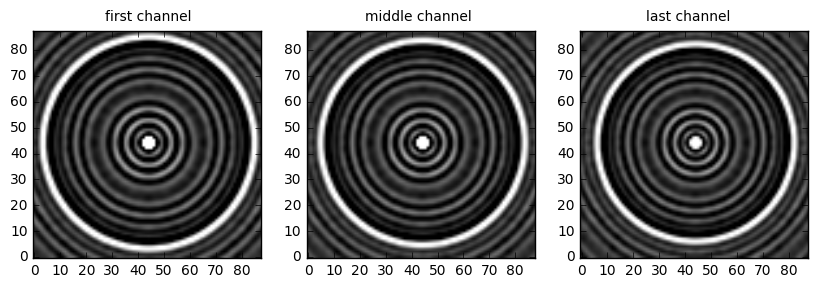

In [327]:
f=fits.open('m01_ns.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel',ha='center')
ppl.figtext(0.51,0.76,'middle channel',ha='center')
ppl.figtext(0.78,0.76,'last channel',ha='center')
ppl.show()

At this point we can make a brief digression on MIRIAD. One may think that, for the original MIRIAD datacube where the pixel size scales with $1/\nu$ and, therefore, the PSF is fixed on the $(x,y,\nu)$ pixel grid (Sec. 1.2), the continuum subtraction error at the position of the sidelobes would not occur. However, this is strictly true only at the reference pixel of the datacube $(l,m)=(0,0)$. Away from this position the $(x,y)$ position of a source would itself change with $\nu$ (dragging with it the associated sidelobes). Therefore, away from the reference pixel, the cube-based continuum subtraction – which is done for each $(x,y)$ independently – would require larger polynomial orders $N$ because it would have to account not only for a source's spectrum but also for its radial shift across the cube as a function of frequency. The polynomial approximation would get progressively worse as the distance from the reference pixel increases.

Returning to the cube regridded to a fixed pixel size, as exaplained above, the change in the sidelobes' position on the sky as a function of frequency means that a cube-based continuum subtraction will not work well at the position of the sidelobes. Their spectrum is more complex than that at the position of a real source, as shown below.

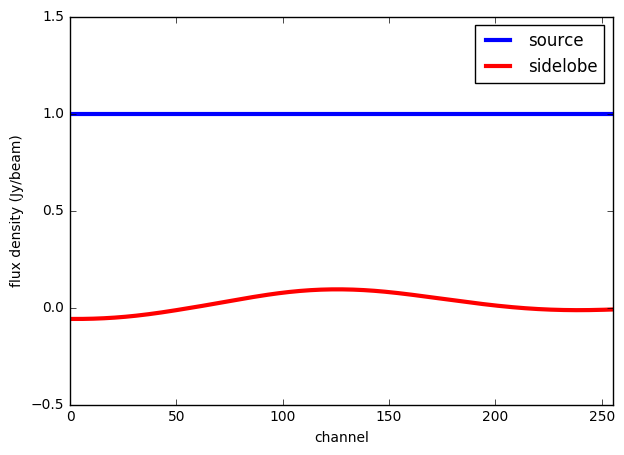

In [352]:
f=fits.open('m01_ns.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(7,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(111)
ppl.plot(np.arange(cube.shape[0]),cube[:,256,256],'b-',lw=3)
ppl.plot(np.arange(cube.shape[0]),cube[:,197,205],'r-',lw=3)
ppl.legend(('source','sidelobe'))
ppl.xlim(0,255)
ppl.ylim(-0.5,1.5)
ppl.xlabel('channel')
ppl.ylabel('flux density (Jy/beam)')
ppl.show()

This plot shows that a higher polynomial order $N$ is necessary to subtract the sidelobe's continuum compared to what is necessary for the continuum source itself. The exact value of $N$ necessary for this purpose will depend on the particular observation and on the particular sidelobe, but in general some residuals will always be present in the continuum-subtracted cube – of course, the question will be whether they are below the noise.

To show the structure of these artefacts we subtract the continuum from the regridded cube using MIRIAD's CONTSUB with a range of polynomial orders.

In [454]:
print '# Executing MIRIAD commands'
for order in [1,2,3]:
    image_noscale_contsub='m01_ns_cs%i'%order
    if os.path.exists(image_noscale_contsub): shutil.rmtree(image_noscale_contsub)
    Run('contsub in=m01_ns out=%s mode=poly,%i contchan=(1,256)'%(image_noscale_contsub,order))
    Run('fits in=%s op=xyout out=%s.fits'%(image_noscale_contsub,image_noscale_contsub))
    Run('rm -rf %s'%(image_noscale_contsub))
print '# Done'

# Executing MIRIAD commands
contsub in=m01_ns out=m01_ns_cs1 mode=poly,1 contchan=(1,256)
fits in=m01_ns_cs1 op=xyout out=m01_ns_cs1.fits
rm -rf m01_ns_cs1
contsub in=m01_ns out=m01_ns_cs2 mode=poly,2 contchan=(1,256)
fits in=m01_ns_cs2 op=xyout out=m01_ns_cs2.fits
rm -rf m01_ns_cs2
contsub in=m01_ns out=m01_ns_cs3 mode=poly,3 contchan=(1,256)
fits in=m01_ns_cs3 op=xyout out=m01_ns_cs3.fits
rm -rf m01_ns_cs3
# Done


We then display the same three channels of the continuum-subctracted cube on the same grey scale as above.

# Plotting m01_ns_cs1.fits
# Plotting m01_ns_cs2.fits
# Plotting m01_ns_cs3.fits


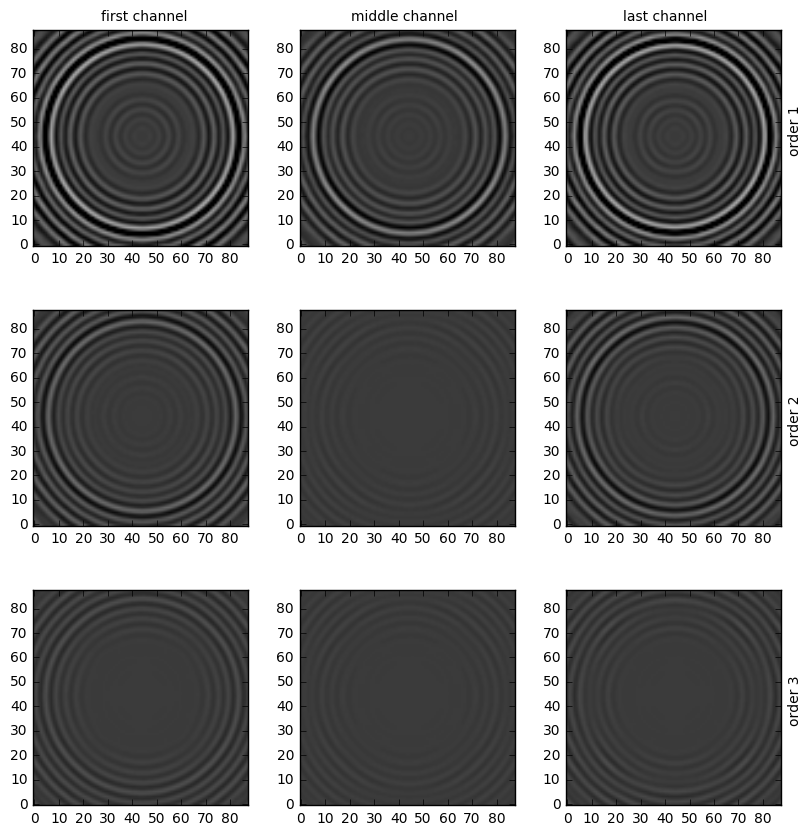

In [329]:
ppl.figure(figsize=(10,10))
ppl.subplots_adjust(wspace=0.1,hspace=0.3)

for order in [1,2,3]:
    image_noscale_contsub='m01_ns_cs%i'%order
    print '# Plotting %s.fits'%(image_noscale_contsub)
    f=fits.open('%s.fits'%image_noscale_contsub)
    cube=f[0].data[0]
    f.close()
    ppl.subplot(3,3,(order-1)*3+1)
    ppl.imshow(cube[0,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
    ppl.subplot(3,3,(order-1)*3+2)
    ppl.imshow(cube[128,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
    ppl.subplot(3,3,(order-1)*3+3)
    ppl.imshow(cube[-1,212:300,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)

ppl.figtext(0.25,0.91,'first channel',ha='center')
ppl.figtext(0.51,0.91,'middle channel',ha='center')
ppl.figtext(0.77,0.91,'last channel',ha='center')
ppl.figtext(0.9,0.80,'order 1',ha='center',va='center',rotation=90)
ppl.figtext(0.9,0.51,'order 2',ha='center',va='center',rotation=90)
ppl.figtext(0.9,0.23,'order 3',ha='center',va='center',rotation=90)
ppl.show()

As expected, for this noise-less ideal case, the cube-based continuum subtraction works perfectly at the position of the flat-spectrum source regardless of the order of the polynomial fit. However, the sidelobe emission is not subtracted well. The quality of the sidelobe continuum subtraction increases with increasing order of the polynomial but some level of residuals will always be present. In this particular case, for N=1 the residual level is between 5 and 10 percent of the source flux density, while this level is about halved for N=3. The impact of these residuals on the scientific goals of an observation depend on the flux density of the sources in the field and on the PSF sidelobe level relative to the other sources of noise and artefacts in the cube.

With reference to the spectra at the position of the source and of a sidelobe shown above, the plot below shows the residual spectra after 2nd-order continuum subtraction at the same positions and on the same flux scale. Once again, this highlights the residual at the position of the sidelobe.

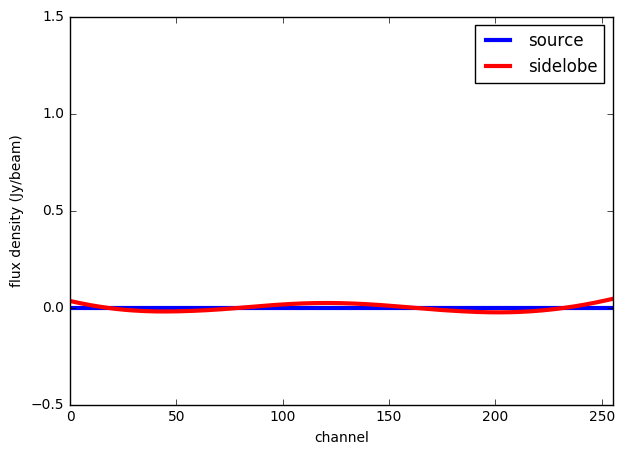

In [353]:
f=fits.open('m01_ns_cs2.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(7,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(111)
ppl.plot(np.arange(cube.shape[0]),cube[:,256,256],'b-',lw=3)
ppl.plot(np.arange(cube.shape[0]),cube[:,197,205],'r-',lw=3)
ppl.legend(('source','sidelobe'))
ppl.xlim(0,255)
ppl.ylim(-0.5,1.5)
ppl.xlabel('channel')
ppl.ylabel('flux density (Jy/beam)')
ppl.show()

### 3.3. Channel selection

The selection of line-free (and RFI-free) channels is critical for a correct polynomial fit and continuum subtraction. Since for a dirty cube the PSF spreads any line emission/absorption at a given channel to all spatial pixels of that channel, the line-free channel selection does not depend on position and must be applied to all $(l,m)$. In fact, this selection is not always straightforward when working with a dirty cube. For example, the continuum emission (sources and sidelobes) may be much brighter than the line emission/absorption, and a few iterations of deconvolution and continuum subtraction may be required before the line-free channels are correctly identified.

### 3.4. Working with  deconvolved cubes

A natural question is whether, since deconvolution may be required to identify the line-free channels, the cube-based continuum subtraction method could be applied directly to the deconvolved cube $I(l,m,\nu)$. This would have the advantage that the PSF sidelobes of both continuum and spectral-line sources have been removed and, therefore, PSF-related continuum subtraction errors would be minimised. Furthermore, since the line emission/absorption has been deconvolved too, and is now localised to a few small regions within each channel, the line-free channel selection could be made position dependent. This could be easily achieved by including a simple outlier rejection algorithm in the polynomial fit, and would maximise the number of fitted channels along each sightline. (In practice, this is not possible in current implementation of the cube-based continuum subtraction in, e.g., CASA and MIRIAD, but has been tried outside these standard packages.)

A singificant issue with subtracting the continuum from a deconvolved cube $I(l,m,\nu)$ is that deconvolution is non-linear and, therefore, leaves residuals and artefacts which vary from channel to channel. This would be particularly true for bright continuum emission and in the presence of significant calibration errors. The following step of continuum subtraction would not remove these artefacts since it fits and subtracts a smooth function. The final result may then be worse than one in which continuum subtraction is performed before deconvolution. In other words, continuum subtraction on the dirty cube $I^\mathrm{D}(l,m,\nu)$ is much more robust against calibration errors. For this reason, it may be better to attempt the cube-based continuum subtraction of a deconvolved cube only after the brightest continuum emission has been subtracted with a different method such as those described in Secs. 4 and 5. This combined approach is discussed in Sec. 6.

## 4. Visibility-based continuum subtraction

### 4.1. Basic method

This approach consists of subtracting the continuum emission directly from the visibilities by modelling the continuum component $V_{ij,\mathrm{c}}(t,\nu)$ with a low order polynomial $V_{ij,\mathrm{c,model}}(t,\nu) = \sum_{n=0}^{N} a_{ij,n}(t)\ \nu^n$. This is done separately on the real and imaginary parts of each visibility spectrum. (The alternative approach of fitting amplitude and phase would be non-linear, would be complicated because of the phase wrapping, and would introduce an amplitude bias which would depend on the signal-to-noise ratio of the data.)


As for the cube-based continuum subtraction, the polynomial fit should only be run on line-free (and RFI-free) channels but their selection is not always straightforward. The line emission/absorption may be too faint to detect in individual visibility spectra, and a few iterations of continuum subtraction and spectral-line imaging may be required to identify the line-free channels correctly.

Since all spectral line sources in the field contribute to all visibility spectra the line-free channel selection should be identical for all spectra. In fact, the signal from spatially-extended spectral line emission may be brighter on short baselines and, therefore, there is scope for a baseline dependent line-free channel selection. This could be easily achieved by including basic outlier rejection in the fit. The same could be useful to reject RFI from the fit.

### 4.2. Limitations: the polynomial approximation

The visibility-based continuum subtraction works only as long as the polynomial approximation for real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ is valid. This approximation becomes progressively worse for larger distances from the phase centre, longer baselines and larger relative bandwidths, as we explain in what follows.

The visibility of a unit point source at distance $\mathbf{s}$ from the phase-tracking centre is:

$V_{ij,\mathrm{c}}(t,\nu) = \cos({2\pi\nu/c \ \mathbf{s}\cdot\mathbf{b}_{ij}}) + i \sin({2\pi\nu/c \ \mathbf{s}\cdot\mathbf{b}_{ij}}$),

where $\mathbf{s}\cdot\mathbf{b}_{ij}$ is a function of time $t$. That is, the variation of both real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ with $\nu$ is represented by a sinusoid whose oscillation rate grows with $\mathbf{s}\cdot\mathbf{b}_{ij}$. When the oscillation is slow, for example because the source is at the phase centre or because the projected baseline is very short, the polynomial approximation is sufficiently good even with order 1. However, when the oscillation is so fast that the observed bandwidth "sees" something of the order of a sinusoid period the polynomial approximation becomes quite poor. At fixed bandwidth, the larger $\mathbf{s}\cdot\mathbf{b}_{ij}$ (either because of a larger distance $\mathbf{s}$ from the phase centre or because of a longer baseline $\mathbf{b}_{ij}$ -- or both), the faster the sinusoidal variation of real and imaginary part of $V_{ij,\mathrm{c}}(t,\nu)$ with frequency, and the poorer the polynomial approximation. Conversely, at fixed $\mathbf{s}\cdot\mathbf{b}_{ij}$, the larger the bandwidth the larger the portion of the sinusoid that we try to approximate with a polynomial and, therefore, the poorer the approximation.

The following example shows the situation for a 100 MHz bandwidth at an observing frequency of 1.4 GHz, projected baseline length of 200 m and 2 km, and distance from the phase centre of 1 arcmin and 10 arcmin.

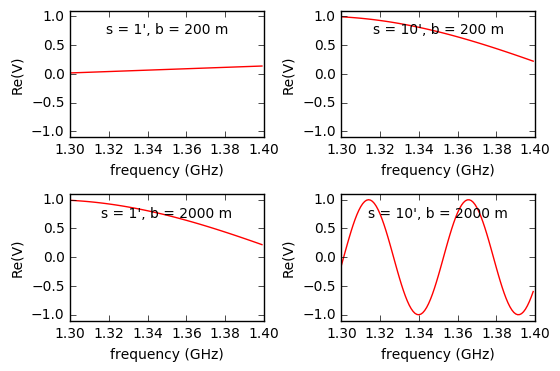

In [3]:
nu=np.arange(1.3,1.4,0.001)*1e+9 # 1-kHz-wide channels over a 100-MHz bandwidth at a frequency of 1.4 GHz
c=2.998e+8
ss=[1.  ,10.  ] # distance from phase centre in arcmin
bb=[200.,2000.] # baseline length in metres
nplot=0
ppl.subplots_adjust(wspace=0.4,hspace=0.45)
for b in bb:
    for s in ss:
        nplot+=1
        v=-np.cos(2*np.pi*nu/c*(s/60/180*np.pi)*b)
        ppl.subplot(2,2,nplot)
        ppl.plot(nu/1e+9,v,'r-')
        ppl.text(1.35,0.7,"s = %i', b = %i m"%(s,b),ha="center")
        ppl.ylim(-1.1,1.1)
        ppl.xlabel('frequency (GHz)')
        ppl.ylabel('Re(V)')
ppl.show()

The figure shows that for a source 10 arcmin from the phase centre fitting the continuum with a low-order polynomial cannot work on a 2 km baseline, unless one has observed a significantly narrower bandwidth (e.g., 20 MHz instead of 100 MHz). On the contrary, for a 200 m baseline and/or for a source 1 arcmin away from the phase centre a low-order polynomial is a good approximation to the data.

The same result can be obtained with a MIRIAD simulation identical to the one created in Sec. 2 except for the position of the point source, which we now place 10 arcmin north of the phase centre. The visibility spectra obtained this way are consistent with the ones shown above (right panels).

In [408]:
print '# Executing MIRIAD commands'
if os.path.exists('sim02.uv'): shutil.rmtree('sim02.uv')
Run('uvgen source=pointsource02.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim02.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28')
Run('uvspec vis=sim02.uv device=sim02_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2')
Run('uvspec vis=sim02.uv device=sim02_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2')
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource02.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim02.uv harange=-6,6,0.016667 systemp=0 lat=-30.7 jyperk=19.28
uvspec vis=sim02.uv device=sim02_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2
uvspec vis=sim02.uv device=sim02_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2
# Done


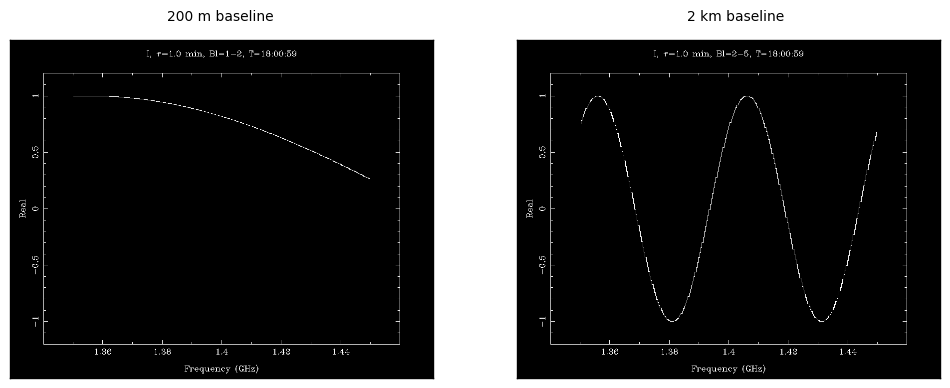

# Done


In [9]:
ppl.figure(figsize=(12,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(121)
ppl.imshow(mim.imread('sim02_200m.png'))
ppl.xticks([])
ppl.yticks([])
ppl.subplot(122)
ppl.imshow(mim.imread('sim02_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.30,0.89,'200 m baseline',ha='center')
ppl.figtext(0.73,0.89,'2 km baseline',ha='center')
ppl.show()
print '# Done'

One could be tempted to get around this limitation by shifting the phase centre to the position of the source that needs to be subtracted. This would work i that were the only source in the sky. However, no source will ever be completely isolated, and each $V_{ij,\mathrm{c}}(t,\nu)$ "sees" other sources too. These sources will be at different positions and may be more difficult to subtract with the new phase centre. Of course in case of a strong, dominant source it may be beneficial to shift the phase centre to its position, but this will not always give satisfactory results. This highlights that this method of continuum subtraction is better suited for interferometers with a small primary beam size (i.e., larger dishes) as most continuum sources are detected close to the phase centre. Interferometers built with smaller dishes see sources out to larger distances from the phase centre. This makes visibility-based continuum subtraction less straightforward (in particular for large bandwidths).

We can use the same MIRIAD simulation above to have a look at the residuals left by this continuum-subtraction method in the visibilities as well as in the spectral line cube. We execute a 2nd order polynomial fit:

In [410]:
print '# Executing MIRIAD commands'
if os.path.exists('sim02_vs.uv'): shutil.rmtree('sim02_vs.uv')
Run('uvlin vis=sim02.uv order=2 options=relax out=sim02_vs.uv')
Run('uvspec vis=sim02_vs.uv device=sim02_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2')
Run('uvspec vis=sim02_vs.uv device=sim02_vs_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2')
print '# Done'

# Executing MIRIAD commands
uvlin vis=sim02.uv order=2 options=relax out=sim02_vs.uv
uvspec vis=sim02_vs.uv device=sim02_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2
uvspec vis=sim02_vs.uv device=sim02_vs_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2
# Done


We then display the same spectra as above, but this time after continuum subtraction:

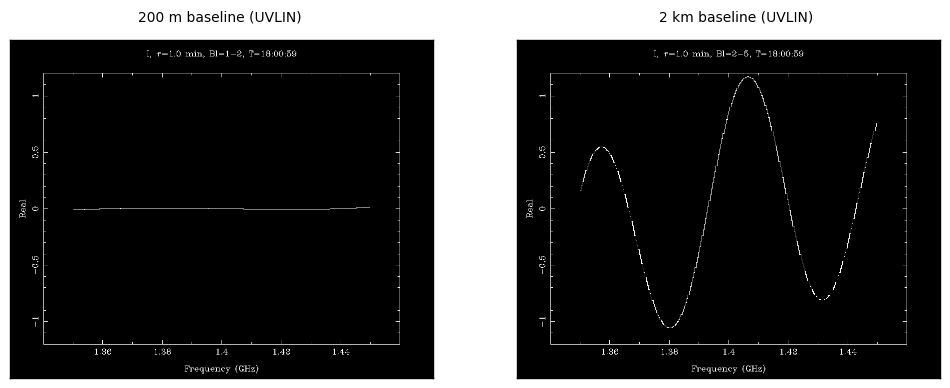

# Done


In [10]:
ppl.figure(figsize=(12,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(121)
ppl.imshow(mim.imread('sim02_vs_200m.png'))
ppl.xticks([])
ppl.yticks([])
ppl.subplot(122)
ppl.imshow(mim.imread('sim02_vs_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.30,0.89,'200 m baseline (UVLIN)',ha='center')
ppl.figtext(0.73,0.89,'2 km baseline (UVLIN)',ha='center')
ppl.show()
print '# Done'

As expected, the continuum is subtracted reasonably well on the short baseline but not on the long baseline. This will leave signatures in the spectral line cube, as we show below by displaying a few channels using the same grey scale adopted in Sec. 3. (Note that we show here the original, not regridded, MIRIAD datacube. Hence, the coordinates $x$ and $y$ of the source and associated residuals change with $\nu$.)

# Executing MIRIAD commands
invert vis=sim02_vs.uv map=m02_vs imsize=512 cell=5 slop=1 robust=0
fits in=m02_vs op=xyout out=m02_vs.fits
rm -rf m02_vs
# Done


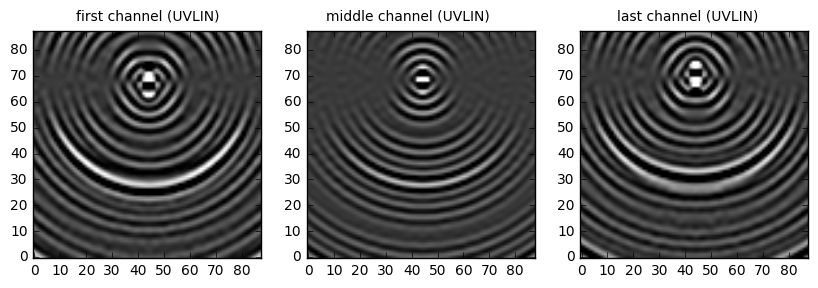

In [455]:
print '# Executing MIRIAD commands'
if os.path.exists('m02_vs'): shutil.rmtree('m02_vs')
Run('invert vis=sim02_vs.uv map=m02_vs imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m02_vs op=xyout out=m02_vs.fits')
Run('rm -rf m02_vs')
print '# Done'

f=fits.open('m02_vs.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,212+100:300+100,212:300],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel (UVLIN)',ha='center')
ppl.figtext(0.50,0.76,'middle channel (UVLIN)',ha='center')
ppl.figtext(0.78,0.76,'last channel (UVLIN)',ha='center')
ppl.show()

### Limitations: noise amplification

Another issue with the visibility-based continuum subtraction is that it modifies the noise characteristics of channels excluded from the polynomial fit relative to those included in it. To see this we repeat the same simulation of Sec. 3 (where the point source is at the phase centre and, therefore, the visibility-based continuum subtraction works well) but this time including some noise.

In [412]:
print '# Executing MIRIAD commands'
if os.path.exists('sim01N.uv'): shutil.rmtree('sim01N.uv')
Run('uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim01N.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28')
Run('uvspec vis=sim01N.uv device=sim01N_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2')
Run('uvspec vis=sim01N.uv device=sim01N_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2')
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource01.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim01N.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28
uvspec vis=sim01N.uv device=sim01N_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2
uvspec vis=sim01N.uv device=sim01N_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2
# Done


The visibility spectra now appear flat because the source is at the phase centre:

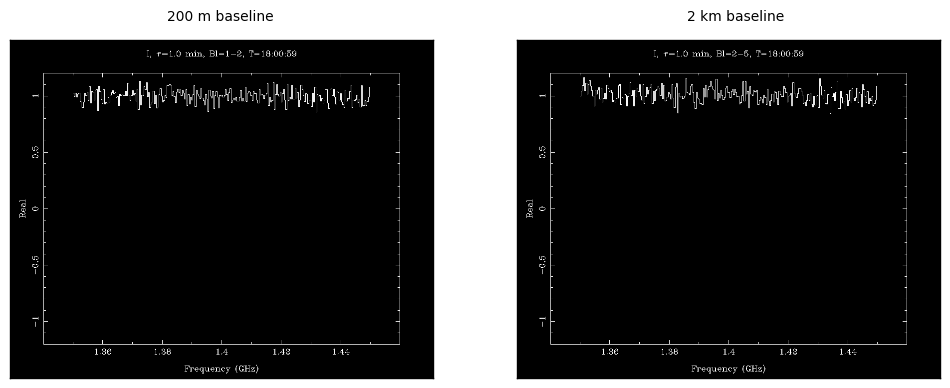

# Done


In [11]:
ppl.figure(figsize=(12,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(121)
ppl.imshow(mim.imread('sim01N_200m.png'))
ppl.xticks([])
ppl.yticks([])
ppl.subplot(122)
ppl.imshow(mim.imread('sim01N_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.30,0.89,'200 m baseline',ha='center')
ppl.figtext(0.73,0.89,'2 km baseline',ha='center')
ppl.show()
print '# Done'

As expected, continuum subtraction works well, as shown by the continuum-subtracted spectra:

# Executing MIRIAD commands
uvlin vis=sim01N.uv order=2 options=relax out=sim01N_vs.uv
uvspec vis=sim01N_vs.uv device=sim01N_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2
uvspec vis=sim01N_vs.uv device=sim01N_vs_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2
# Done


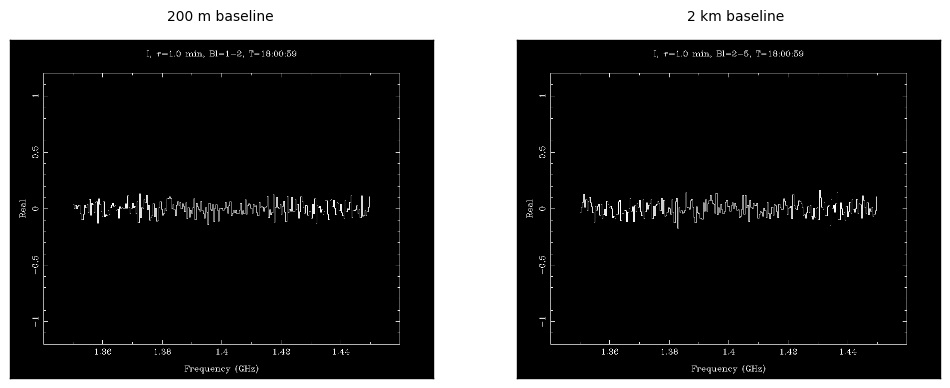

In [415]:
print '# Executing MIRIAD commands'
if os.path.exists('sim01N_vs.uv'): shutil.rmtree('sim01N_vs.uv')
Run('uvlin vis=sim01N.uv order=2 options=relax out=sim01N_vs.uv')
Run('uvspec vis=sim01N_vs.uv device=sim01N_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-1.2,1.2')
Run('uvspec vis=sim01N_vs.uv device=sim01N_vs_200m.png/png nxy=1,1 select=an(1)(2),vis(1,10) axis=freq,real yrange=-1.2,1.2')
print '# Done'

ppl.figure(figsize=(12,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(121)
ppl.imshow(mim.imread('sim01N_vs_200m.png'))
ppl.xticks([])
ppl.yticks([])
ppl.subplot(122)
ppl.imshow(mim.imread('sim01N_vs_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.30,0.89,'200 m baseline',ha='center')
ppl.figtext(0.73,0.89,'2 km baseline',ha='center')
ppl.show()
print '# Done'

We investigate the amplification of the noise in channels excluded from the fit by fitting the continuum with polynomial orders $N$ from 0 to 3 and using *i)* all channels, and *ii)* the first 70 and the last 70 channels (for a total of ~55% of the available band).

In [443]:
print '# Executing MIRIAD commands'
Run('uvlin vis=sim01N.uv order=0 options=relax out=sim01N_vs_0a.uv')
Run('invert vis=sim01N_vs_0a.uv map=m01N_vs_0a imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_0a op=xyout out=m01N_vs_0a.fits')
Run('rm -rf sim01N_vs_0a.uv m01N_vs_0a')

Run('uvlin vis=sim01N.uv order=0 options=relax out=sim01N_vs_0b.uv chans=1,70,187,256')
Run('invert vis=sim01N_vs_0b.uv map=m01N_vs_0b imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_0b op=xyout out=m01N_vs_0b.fits')
Run('rm -rf sim01N_vs_0b.uv m01N_vs_0b')

Run('uvlin vis=sim01N.uv order=1 options=relax out=sim01N_vs_1a.uv')
Run('invert vis=sim01N_vs_1a.uv map=m01N_vs_1a imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_1a op=xyout out=m01N_vs_1a.fits')
Run('rm -rf sim01N_vs_1a.uv m01N_vs_1a')

Run('uvlin vis=sim01N.uv order=1 options=relax out=sim01N_vs_1b.uv chans=1,70,187,256')
Run('invert vis=sim01N_vs_1b.uv map=m01N_vs_1b imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_1b op=xyout out=m01N_vs_1b.fits')
Run('rm -rf sim01N_vs_1b.uv m01N_vs_1b')

Run('uvlin vis=sim01N.uv order=2 options=relax out=sim01N_vs_2a.uv')
Run('invert vis=sim01N_vs_2a.uv map=m01N_vs_2a imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_2a op=xyout out=m01N_vs_2a.fits')
Run('rm -rf sim01N_vs_2a.uv m01N_vs_2a')

Run('uvlin vis=sim01N.uv order=2 options=relax out=sim01N_vs_2b.uv chans=1,70,187,256')
Run('invert vis=sim01N_vs_2b.uv map=m01N_vs_2b imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_2b op=xyout out=m01N_vs_2b.fits')
Run('rm -rf sim01N_vs_2b.uv m01N_vs_2b')

Run('uvlin vis=sim01N.uv order=3 options=relax out=sim01N_vs_3a.uv')
Run('invert vis=sim01N_vs_3a.uv map=m01N_vs_3a imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_3a op=xyout out=m01N_vs_3a.fits')
Run('rm -rf sim01N_vs_3a.uv m01N_vs_3a')

Run('uvlin vis=sim01N.uv order=3 options=relax out=sim01N_vs_3b.uv chans=1,70,187,256')
Run('invert vis=sim01N_vs_3b.uv map=m01N_vs_3b imsize=512 cell=5 slop=1 robust=0')
Run('fits in=m01N_vs_3b op=xyout out=m01N_vs_3b.fits')
Run('rm -rf sim01N_vs_3b.uv m01N_vs_3b')

#Run('uvmodel vis=sim01N.uv options=mfs,subtract out=sim01N_ms.uv')
#Run('invert vis=sim01N_ms.uv map=m01N_ms imsize=512 cell=5 slop=1 robust=0')
#Run('fits in=m01N_ms op=xyout out=m01N_ms.fits')
#Run('rm -rf sim01N_ms.uv m01N_ms')
print '# Done'

# Executing MIRIAD commands
uvlin vis=sim01N.uv order=0 options=relax out=sim01N_vs_0a.uv
invert vis=sim01N_vs_0a.uv map=m01N_vs_0a imsize=512 cell=5 slop=1 robust=0
fits in=m01N_vs_0a op=xyout out=m01N_vs_0a.fits
rm -rf sim01N_vs_0a.uv m01N_vs_0a
uvlin vis=sim01N.uv order=0 options=relax out=sim01N_vs_0b.uv chans=1,70,187,256
invert vis=sim01N_vs_0b.uv map=m01N_vs_0b imsize=512 cell=5 slop=1 robust=0
fits in=m01N_vs_0b op=xyout out=m01N_vs_0b.fits
rm -rf sim01N_vs_0b.uv m01N_vs_0b
uvlin vis=sim01N.uv order=1 options=relax out=sim01N_vs_1a.uv
invert vis=sim01N_vs_1a.uv map=m01N_vs_1a imsize=512 cell=5 slop=1 robust=0
fits in=m01N_vs_1a op=xyout out=m01N_vs_1a.fits
rm -rf sim01N_vs_1a.uv m01N_vs_1a
uvlin vis=sim01N.uv order=1 options=relax out=sim01N_vs_1b.uv chans=1,70,187,256
invert vis=sim01N_vs_1b.uv map=m01N_vs_1b imsize=512 cell=5 slop=1 robust=0
fits in=m01N_vs_1b op=xyout out=m01N_vs_1b.fits
rm -rf sim01N_vs_1b.uv m01N_vs_1b
uvlin vis=sim01N.uv order=2 options=relax out=sim01N_v

The plots below show the measured noise level as a function of channel number for the different polynomial orders using all channels for the fit (left) and excluding the central ~45 percent of all channels (right).

# Reading cubes ...
# Plotting ...


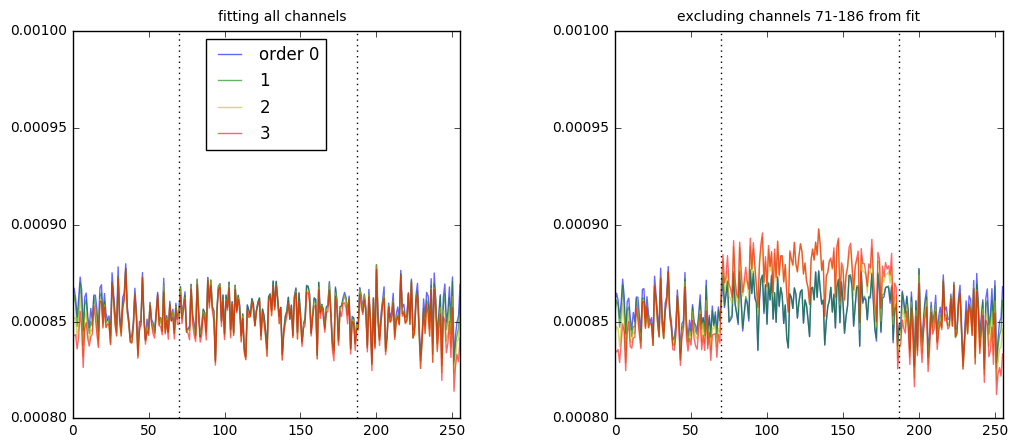

In [448]:
print '# Reading cubes ...'

f=fits.open('m01N_vs_0a.fits')
cube=f[0].data[0]
std0a=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_1a.fits')
cube=f[0].data[0]
std1a=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_2a.fits')
cube=f[0].data[0]
std2a=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_3a.fits')
cube=f[0].data[0]
std3a=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_0b.fits')
cube=f[0].data[0]
std0b=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_1b.fits')
cube=f[0].data[0]
std1b=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_2b.fits')
cube=f[0].data[0]
std2b=cube.std(axis=(1,2))
f.close()

f=fits.open('m01N_vs_3b.fits')
cube=f[0].data[0]
std3b=cube.std(axis=(1,2))
f.close()

#f=fits.open('m01N_ms.fits')
#cube=f[0].data[0]
#stdms=cube.std(axis=(1,2))
#f.close()


print '# Plotting ...'

ppl.figure(figsize=(12,5))
ppl.subplots_adjust(wspace=0.4)
ppl.subplot(121)
#ppl.plot(np.arange(stdms.shape[0]),stdms,'k-',lw=1,alpha=0.6)
ppl.plot(np.arange(std0a.shape[0]),std0a,'b-',lw=1,alpha=0.6)
ppl.plot(np.arange(std1a.shape[0]),std1a,'g-',lw=1,alpha=0.6)
ppl.plot(np.arange(std2a.shape[0]),std2a,'y-',lw=1,alpha=0.6)
ppl.plot(np.arange(std3a.shape[0]),std3a,'r-',lw=1,alpha=0.6)
ppl.axvline(x=70,linestyle=':',color='k')
ppl.axvline(x=187,linestyle=':',color='k')
ppl.xlim(0,255)
ppl.ylim(0.0008,0.001)
ppl.legend(('order 0','1','2','3'),loc='upper center')

ppl.subplot(122)
#ppl.plot(np.arange(stdms.shape[0]),stdms,'k-',lw=1,alpha=0.6)
ppl.plot(np.arange(std0b.shape[0]),std0b,'b-',lw=1,alpha=0.6)
ppl.plot(np.arange(std1b.shape[0]),std1b,'g-',lw=1,alpha=0.6)
ppl.plot(np.arange(std2b.shape[0]),std2b,'y-',lw=1,alpha=0.6)
ppl.plot(np.arange(std3b.shape[0]),std3b,'r-',lw=1,alpha=0.6)
ppl.axvline(x=70,linestyle=':',color='k')
ppl.axvline(x=187,linestyle=':',color='k')
ppl.xlim(0,255)
ppl.ylim(0.0008,0.001)

ppl.figtext(0.30,0.92,'fitting all channels',ha='center')
ppl.figtext(0.73,0.92,'excluding channels 71-186 from fit',ha='center')

The noise increase, which is apparent in the channels excluded from the fit, becomes more significant with increasing order of the fit and with decreasing fraction of the bandwidth which is used for the fit. A discussion of this effect is available at http://www.atnf.csiro.au/computing/software/miriad/userguide/node132.html.

### 4.3. Visibility-based continuum subtraction and calibration errors

One significant advantage of visibility-based continuum subtraction is that it is basically insensitive to time-dependent gain calibration errors. That is, once a good bandpass calibration has been achieved, the method works equally well regardless of whether a frequency-independent, time-dependent gain calibration has been performed. The reason is that this method works on each visibility spectrum (i.e., at fixed time) independently. For each of these spectra the application of a gain calibration which depends on time but not on frequency does not change the spectral shape and, therefore, the quality of a polynomial fit.

Of course, if visibility-based continuum subtraction is used on a dataset with significant gain calibration errors the resulting spectral line cube will show artefacts at the channels with significant emission/absorption. However, the level of those artefacts will depend on the brightness of the line signal and not of the continuum. This is important since the line signal is typically much fainter than the continuum one, and represents a significant advantage compared to the method discussed in the next Section.

## 5. Model-based continuum subtraction

### 5.1. Basic method

Both the cube-based and visibility-based continuum subctraction methods described above suffer from limitations that are related to chromatic effects. In the case of the cube-based continuum subtraction the issue is that the PSF pattern scales with frequency and, therefore, the continuum spectral shape at the position of a source's sidelobes is complex and difficult to subtract (Sec. 3). In the case of the visbility-based continuum subtraction the issue is that, since $u$ and $v$ scale with frequency and, therefore, change from channel to channel within each visibility spectrum, the shape of such spectrum is not well approximated by a polynomial for large distances from the phase centre, long baselines and large bandwidths (Sec. 4).

In this section we discuss the alternative method of performing a model-based continuum subtraction. This method gets around these chromatic issues. It consists of modelling the radio continuum sky and subtracting the Fourier transform of the model from the visibilities. The operation of Fourier transform is done for each channel in the visibility dataset, and this takes properly into account all chromatic effects.

Compared to cube- and visibility-based continuum subtraction this method is slower, especially if working on a large bandwidth as this requires modelling and Fourier transforming not only the flux density but also the spectral shape of each source on the sky. For this reason in many cases it is preferable to use the other methods as long as they give results of sufficient quality. However, the current trend of increasing bandwidth for spectral-line experiments is making model-based continuum subtraction increasingly more important.

To illustrate this method we consider a simulation which combines those used in Secs. 3 and 4. It consists of a point source at the phase centre and another one with half the flux 10 arcmin north of the phase centre. In this case we include some noise in the simulation, corresponding to a noise level of ~1 mJy/beam in a single channel of the cube. We then image the data.

As a reminder, we display a few channels before and after cube-based continuum subtraction to show, once again, the chromatic effect of the sidelobe movement as a function of frequency. (The images below are displayed with the same colour scale used above.)

In [335]:
print '# Executing MIRIAD commands'
if os.path.exists('sim03.uv'): shutil.rmtree('sim03.uv')
if os.path.exists('m03'): shutil.rmtree('m03')
if os.path.exists('b03'): shutil.rmtree('b03')
if os.path.exists('m03_ns'): shutil.rmtree('m03_ns')
if os.path.exists('m03_ns_cs'): shutil.rmtree('m03_ns_cs')
Run('uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim03.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28')
Run('invert vis=sim03.uv map=m03 beam=b03 imsize=512 cell=5 slop=1 robust=0')
Run('regrid in=m03 out=m03_ns options=noscale')
Run('fits in=m03_ns op=xyout out=m03_ns.fits')
Run('contsub in=m03_ns, out=m03_ns_cs mode=poly,3 contchan=(1,256)')
Run('fits in=m03_ns_cs op=xyout out=m03_ns_cs.fits')
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim03.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28
invert vis=sim03.uv map=m03 beam=b03 imsize=512 cell=5 slop=1 robust=0
regrid in=m03 out=m03_ns options=noscale
fits in=m03_ns op=xyout out=m03_ns.fits
contsub in=m03_ns, out=m03_ns_cs mode=poly,3 contchan=(1,256)
fits in=m03_ns_cs op=xyout out=m03_ns_cs.fits
# Done


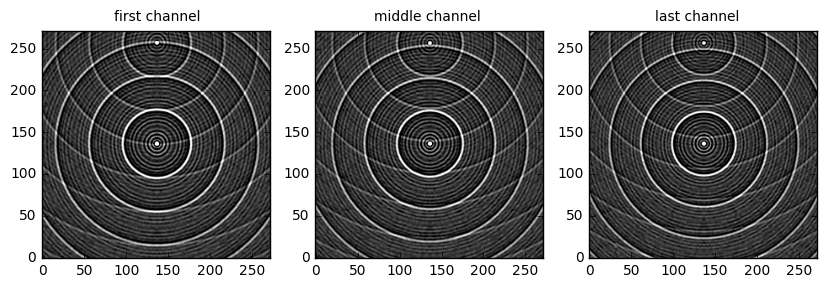

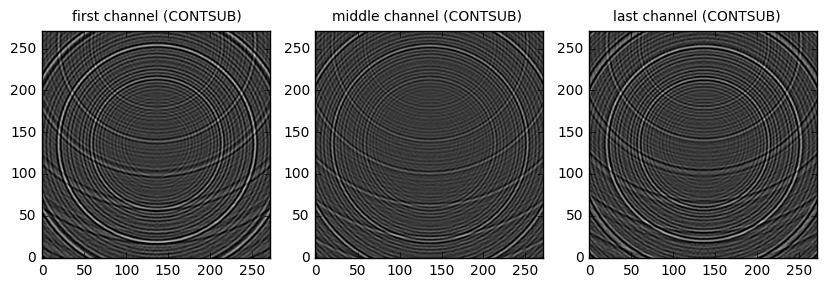

In [393]:
f=fits.open('m03_ns.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel',ha='center')
ppl.figtext(0.51,0.76,'middle channel',ha='center')
ppl.figtext(0.78,0.76,'last channel',ha='center')
ppl.show()

f=fits.open('m03_ns_cs.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel (CONTSUB)',ha='center')
ppl.figtext(0.51,0.76,'middle channel (CONTSUB)',ha='center')
ppl.figtext(0.78,0.76,'last channel (CONTSUB)',ha='center')
ppl.show()

Furthermore, also for this new simulation we can see the rapid variation of the visibilities as a function of frequency on long baselines, which complicates visibility-based continuum subtraction.

# Executing MIRIAD commands
uvlin vis=sim03.uv order=3 options=relax out=sim03_vs.uv
uvspec vis=sim03.uv device=sim03_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2
uvspec vis=sim03_vs.uv device=sim03_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2
# Done


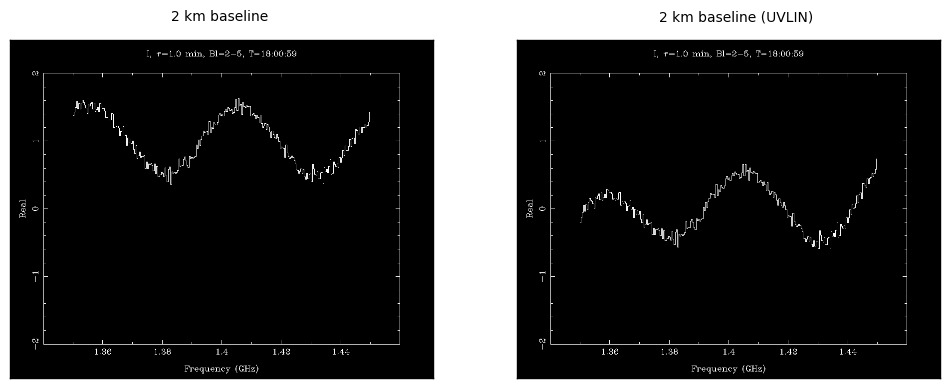

# Done


In [4]:
if os.path.exists('sim03_vs.uv'): shutil.rmtree('sim03_vs.uv')
print '# Executing MIRIAD commands'
Run('uvlin vis=sim03.uv order=3 options=relax out=sim03_vs.uv')
Run('uvspec vis=sim03.uv device=sim03_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2')
Run('uvspec vis=sim03_vs.uv device=sim03_vs_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2')
print '# Done'

ppl.figure(figsize=(12,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(121)
ppl.imshow(mim.imread('sim03_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.subplot(122)
ppl.imshow(mim.imread('sim03_vs_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.30,0.89,'2 km baseline',ha='center')
ppl.figtext(0.73,0.89,'2 km baseline (UVLIN)',ha='center')
ppl.show()
print '# Done'

In what follows we show that the model-based continuum subtraction gets around these issues. We make a multi-frequency-synthesis model of the continuum sky, Fourier transform it and subtract it from the visibilities. (Note that we use an image-based mask to define clean regions.)

In [316]:
if os.path.exists('mfs03_m00'): shutil.rmtree('mfs03_m00')
if os.path.exists('mfs03_b'): shutil.rmtree('mfs03_b')
if os.path.exists('mfs03_msk'): shutil.rmtree('mfs03_msk')
if os.path.exists('mfs03_c01'): shutil.rmtree('mfs03_c01')
if os.path.exists('mfs03_m01'): shutil.rmtree('mfs03_m01')
if os.path.exists('mfs03_c02'): shutil.rmtree('mfs03_c02')
if os.path.exists('mfs03_m02'): shutil.rmtree('mfs03_m02')
if os.path.exists('sim03_ms.uv'): shutil.rmtree('sim03_ms.uv')
print '# Executing MIRIAD commands'
Run('invert vis=sim03.uv map=mfs03_m00 beam=mfs03_b imsize=1024 cell=3 slop=1 robust=-2 options=mfs,double')
Run('maths exp=mfs03_m00 mask=mfs03_m00.gt.0.2 out=mfs03_msk')
Run('clean map=mfs03_m00 beam=mfs03_b region=mask(mfs03_msk) cutoff=1e-4 niters=1e+9 out=mfs03_c01')
Run('restor map=mfs03_m00 beam=mfs03_b model=mfs03_c01 out=mfs03_m01')
Run('rm -rf mfs03_msk')
Run('maths exp=mfs03_m00 mask=mfs03_m01.gt.0.1 out=mfs03_msk')
Run('clean map=mfs03_m00 beam=mfs03_b region=mask(mfs03_msk) cutoff=1e-4 niters=1e+9 out=mfs03_c02')
Run('restor map=mfs03_m00 beam=mfs03_b model=mfs03_c02 out=mfs03_m02')
Run('uvmodel vis=sim03.uv options=subtract,mfs model=mfs03_c02 out=sim03_ms.uv')
print '# Done'

# Executing MIRIAD commands
invert vis=sim03.uv map=mfs03_m00 beam=mfs03_b imsize=1024 cell=3 slop=1 robust=-2 options=mfs,double
maths exp=mfs03_m00 mask=mfs03_m00.gt.0.2 out=mfs03_msk
clean map=mfs03_m00 beam=mfs03_b region=mask(mfs03_msk) cutoff=1e-4 niters=1e+9 out=mfs03_c01
restor map=mfs03_m00 beam=mfs03_b model=mfs03_c01 out=mfs03_m01
rm -rf mfs03_msk
maths exp=mfs03_m00 mask=mfs03_m01.gt.0.1 out=mfs03_msk
clean map=mfs03_m00 beam=mfs03_b region=mask(mfs03_msk) cutoff=1e-4 niters=1e+9 out=mfs03_c02
restor map=mfs03_m00 beam=mfs03_b model=mfs03_c02 out=mfs03_m02
uvmodel vis=sim03.uv options=subtract,mfs model=mfs03_c02 out=sim03_ms.uv
# Done


We then display a few channels of a cube made from the continuum subtracted dataset and show a visibility spectrum to illustrate the quality of the continuum subtraction compared to what can be achieved with the cube-based and visibility-based methods.

# Executing MIRIAD commands
invert vis=sim03_ms.uv map=m03_ms imsize=512 cell=5 slop=1 robust=0
regrid in=m03_ms out=m03_ms_ns options=noscale
fits in=m03_ms_ns op=xyout out=m03_ms_ns.fits
uvspec vis=sim03_ms.uv device=sim03_ms_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2
# Done


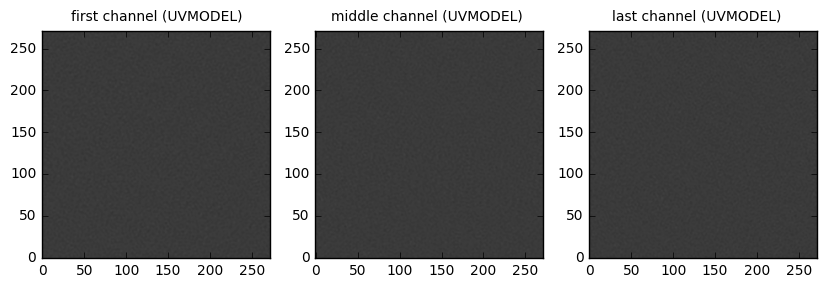

In [399]:
if os.path.exists('m03_ms'): shutil.rmtree('m03_ms')
if os.path.exists('m03_ms_ns'): shutil.rmtree('m03_ms_ns')
print '# Executing MIRIAD commands'
Run('invert vis=sim03_ms.uv map=m03_ms imsize=512 cell=5 slop=1 robust=0')
Run('regrid in=m03_ms out=m03_ms_ns options=noscale')
Run('fits in=m03_ms_ns op=xyout out=m03_ms_ns.fits')
Run('uvspec vis=sim03_ms.uv device=sim03_ms_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2')
print '# Done'

f=fits.open('m03_ms_ns.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel (UVMODEL)',ha='center')
ppl.figtext(0.51,0.76,'middle channel (UVMODEL)',ha='center')
ppl.figtext(0.78,0.76,'last channel (UVMODEL)',ha='center')
ppl.show()

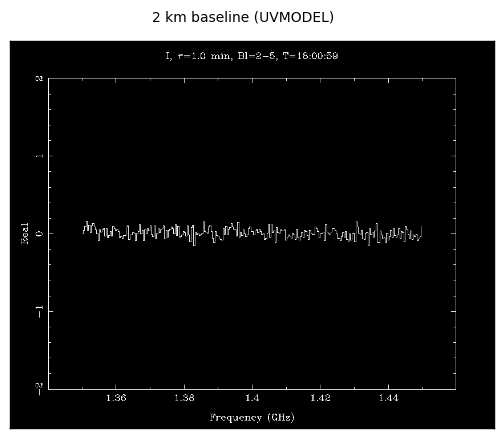

# Done


In [12]:
ppl.figure(figsize=(7,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(111)
ppl.imshow(mim.imread('sim03_ms_2km.png'))
ppl.xticks([])
ppl.yticks([])
ppl.figtext(0.5,0.94,'2 km baseline (UVMODEL)',ha='center')
ppl.show()
print '# Done'

As expected, this method does not suffer from the chromatic effects that limit the use of cube- and visibility-based continuum subtaction. Furthermore, multi-frequency synthesis allows the modelling of the spectral shape of each source in the field. Therefore, although here we analyse a case of flat spectra, the method can handle more complex source populations.

### 5.2. Limitations: imperfect model

A limit of this continuum subtraction method is that it relies on the correct modelling of the continuum source population in the field. The model will of course never be perfect, and this will result in residual artefacts in the spectral line datacube. Common issues are with:
* sources which have not been included in the model because they are too close to the detection limit, but leave a recognisable feature in the datacube (i.e., a slight offset of the spectrum from zero at the position of the source);
* sources which have been included in the model but whose brightness or spectral shape is not described accurately by the model; this could happen with sources with a complex 2D structure or spectral shape (intrinsic or caused by, e.g., their position within the primary beam).

### 5.3. Limitations: calibration errors

The other important limitation of this method is that, unlike cube- and especially visibility-based continuum subtraction, it does not work well in the presence of calibration errors. The reason is that the method requires a good model of the continuum emission in order to subtract it, and poor calibration is a substantial obstacle to getting such model. Furthermore, even in the presence of a perfect model (e.g., obtained from previous, better data), gain errors will result in artefacts whose brightness is proportional to the model sources' flux density. These artefacts are not removed by this continuum subtraction method.

In simple terms, this method allows us to Fourier transform and subtract and ideal continuum model from the visibilities, but all calibration artefacts present in the continuum image and obviously not included in the model will remain in the data with a brightness proportional to that of the subtracted continuum flux,  and corrupt the spectral-line cube. This is different from the visibility-based continuum subtraction, where both continuum sources and associated artefacts are subtracted from the data in a time-dependent way, and calibration errors result in residual artefacts whose brightness is proportional to that of the spectral line (usually much fainter than the continuum).

An example of this behaviour can be easily obtained with another MIRIAD simulation where we introduced a gain phase noise term, which we do not calibrate. This term effectively introduces a noise term associated to the continuum emission in the data, but model-based continuum subtraction does not remove it.

In [451]:
if os.path.exists('sim04.uv'): shutil.rmtree('sim04.uv')
if os.path.exists('mfs04_m00'): shutil.rmtree('mfs04_m00')
if os.path.exists('mfs04_b'): shutil.rmtree('mfs04_b')
if os.path.exists('mfs04_msk'): shutil.rmtree('mfs04_msk')
if os.path.exists('mfs04_c01'): shutil.rmtree('mfs04_c01')
if os.path.exists('mfs04_m01'): shutil.rmtree('mfs04_m01')
if os.path.exists('sim04_ms.uv'): shutil.rmtree('sim04_ms.uv')
if os.path.exists('m04_ms'): shutil.rmtree('m04_ms')
if os.path.exists('m04_ms_ns'): shutil.rmtree('m04_ms_ns')
print '# Executing MIRIAD commands'
Run('uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim04.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28 pnoise=20')
Run('invert vis=sim04.uv map=mfs04_m00 beam=mfs04_b imsize=1024 cell=3 slop=1 robust=-2 options=mfs,double')
Run('maths exp=mfs04_m00 mask=mfs03_m01.gt.0.1 out=mfs04_msk')
Run('clean map=mfs04_m00 beam=mfs04_b region=mask(mfs04_msk) cutoff=1e-4 niters=1e+9 out=mfs04_c01')
Run('restor map=mfs04_m00 beam=mfs04_b model=mfs04_c01 out=mfs04_m01')
Run('uvmodel vis=sim04.uv options=subtract,mfs model=mfs04_c01 out=sim04_ms.uv')
Run('invert vis=sim04_ms.uv map=m04_ms imsize=512 cell=5 slop=1 robust=0')
Run('regrid in=m04_ms out=m04_ms_ns options=noscale')
Run('fits in=m04_ms_ns op=xyout out=m04_ms_ns.fits')
Run('uvspec vis=sim04_ms.uv device=sim04_ms_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2')
print '# Done'

# Executing MIRIAD commands
uvgen source=pointsource03.txt ant=ew_layout.txt baseunit=-51.0204 radec=19:39:25.0,-83:42:46 freq=1.4,0 corr=256,1,0,100 out=sim04.uv harange=-6,6,0.016667 systemp=30 lat=-30.7 jyperk=19.28 pnoise=20
invert vis=sim04.uv map=mfs04_m00 beam=mfs04_b imsize=1024 cell=3 slop=1 robust=-2 options=mfs,double
maths exp=mfs04_m00 mask=mfs03_m01.gt.0.1 out=mfs04_msk
clean map=mfs04_m00 beam=mfs04_b region=mask(mfs04_msk) cutoff=1e-4 niters=1e+9 out=mfs04_c01
restor map=mfs04_m00 beam=mfs04_b model=mfs04_c01 out=mfs04_m01
uvmodel vis=sim04.uv options=subtract,mfs model=mfs04_c01 out=sim04_ms.uv
invert vis=sim04_ms.uv map=m04_ms imsize=512 cell=5 slop=1 robust=0
regrid in=m04_ms out=m04_ms_ns options=noscale
fits in=m04_ms_ns op=xyout out=m04_ms_ns.fits
uvspec vis=sim04_ms.uv device=sim04_ms_2km.png/png  nxy=1,1 select=an(2)(5),vis(1,10) axis=freq,real yrange=-2,2
# Done


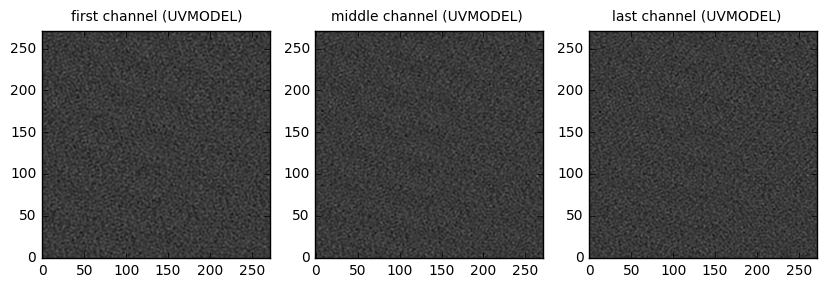

In [452]:
f=fits.open('m04_ms_ns.fits')
cube=f[0].data[0]
f.close()

ppl.figure(figsize=(10,5))
#ppl.subplots_adjust(wspace=0.4,hspace=0.45)
ppl.subplot(131)
ppl.imshow(cube[0,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(132)
ppl.imshow(cube[128,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.subplot(133)
ppl.imshow(cube[-1,120:392,120:392],origin='lower',cmap='gray',vmin=-0.03,vmax=0.1)
ppl.figtext(0.24,0.76,'first channel (UVMODEL)',ha='center')
ppl.figtext(0.51,0.76,'middle channel (UVMODEL)',ha='center')
ppl.figtext(0.78,0.76,'last channel (UVMODEL)',ha='center')
ppl.show()

The noise in these channel maps is clearly larger compared to the above ideal case with no calibration errors. Of course, this noise would be much reduced if the gains were (self-) calibrated.

While here we show this effect as an uncalibrated phase noise term, in general it will appear as artefacts clearly distinct from noise and associated to the brightest continuum sources in the field.

## 6. Concluding remarks

As highlighted in this chapter, no continuum subtraction method is perfect. Cube-based and visibility-based continuum subtraction suffers from issues related to the frequency scaling intrinsic to interferometers. Model-based continuum subtraction gets around those issues and is therefore a better method for data taken over a large relative bandwidth, but it is more sensitive to errors in our calibration of the data and in our modelling of the continuum emission. The fact that different methods have limitations of different nature suggests that using multiple methods on a same dataset may get us closer to a good result.

For example, model-based continuum subtraction could be used to remove most of the emission in a field without suffering from chromatic effects, and cube- or visibility-based subtraction could be used to remove the residual, faint continuum emission and artefacts resulting from poor modelling of the continuum sources or poor calibration. This combination of approaches is used often.

In an era of large datasets, the choice of a continuum subtraction method may also be driven by the available computing resources. For example, if a visibility datset is a lot larger than the datacube made from it, it may be computationally cheaper to subtract the continuum from the cube rather than from the visibilities (there would be many less cube spectra than visibility spectra).

### Bibliography

<a href="http://adsabs.harvard.edu/abs/1992A%26A...258..583C">Cornwell, Uson & Addad 1992, A&A, 258, 583</a>

<a href="http://adsabs.harvard.edu/abs/1999ASPC..180..229R">Rupen 1999, ASPC, 180, 229</a>

<a href="http://adsabs.harvard.edu/abs/1994A%26AS..107...55S">Salt 1994, A&AS, 107, 55</a>

<a href="http://adsabs.harvard.edu/abs/1983ApJ...267..528V">van Gorkom & Ekers 1983, ApJ, 267, 528</a>

<a href="http://adsabs.harvard.edu/abs/1986syim.conf..177V">van Gorkom & Ekers 1986, Synthesis imaging, 177</a>

<a href="http://adsabs.harvard.edu/abs/1989ASPC....6..341V">van Gorkom & Ekers 1989, ASPC, 6, 341</a>

<a href="http://adsabs.harvard.edu/abs/1990A%26A...239L...5V">van Langevelde & Cotton 1990, A&A, 239L, 5</a>

<a href="http://adsabs.harvard.edu/abs/2015MNRAS.453.2399W">Wang et al. 2015, MNRAS, 453, 2399</a>

### Chapter Author: Paolo Serra